# **AI4ER Guided Team Challenge - Slow Earthquake Time Series Forecasting**
## Applying Machine Learning to Earthquake Data from Simulations, the Laboratory and Nature
**Authors:** Camilla Giulia Billari<sup>1</sup>, Pritthijit Nath<sup>1</sup>, Jakob Poffley<sup>1</sup>, Thomas Ratsakatika<sup>1</sup>, Alexandre Shinebourne<sup>1</sup>

**Supervisor:** Adriano Gualandi<sup>1</sup>

_<sup>1</sup> University of Cambridge_

Note: ChatGPT has been used to add comments to the code in some instances.
___

## Introduction

This notebook allows the user to train and evaluate a machine learning model on their choice of simulated or laboratory "labquake" shear stress data, or slow earthquake slip potency data from Cascadia. It provides a step-by-step walkthrough of our pre-processing, training and evaluation logic, complementing the script-based implementation referenced in the README. The notebook relies on functions stored in the "utils" and "scripts/models" folders, to which all team members have contributed.

This notebook is designed to enable the user to easily modify the following parameters:

- **Model type:** Long Short-Term Memory (LSTM) or Temporal Convolutional Network (TCN)
- **Data source:** Simulations (b726, b698, i417), Laboratory (p4581, p4679, b726, b698, i417) or Nature (Cascadia)
- **Input features:** Shear stress/slip potency [required], variance, first derivative, second derivative, time since peak, time since failure [optional]
- **Data pre-processing:** Smoothing window, downsampling factor, validation/test set size
- **Modelling hyperparameters:** Forecast steps, lookback steps, number of epochs, hidden layer size, number of layers (LSTM only), kernel size (TCN only), dropout rate (TCN only)

Once trained, the model will generate one-shot (as opposed to auto-regressive) multi-step predictions of shear stress/slip potency. The accuracy of the model can be evaluated on using Root Mean Squared Error (RMSE) and R<sup>2</sup> statistics, as well as visually using the plotting functions.

Further details on the data and methodology, as well as an analysis and discussion of the results can be found in the accompanying report.
___

## Step 1: Environment set-up and imports

This notebook and associated functions have been designed to work in a Conda environment within a JASMIN group workspace. New users must therefore install the Conda environment, download the data to their working directory, and ensure the file paths are correct.

#### Installing the Conda environment

1. Install Miniconda if required (https://docs.anaconda.com/free/miniconda/miniconda-install/)
2. Source Conda and ensure it is properly installed:

   `source ~/miniconda3/bin/activate`

   `conda --version`
3. Clone the GitHub repository (https://github.com/ai4er-cdt/earthquake-predictability.git) to your desired location.
4. Navigate to the earthquake-predictability folder and create the Conda environment:

   `conda env create -f environment.yaml` if your machine has a GPU, otherwise use `conda env create -f environment-nogpu.yaml` 

   `conda activate gtc_env`

#### Download the slow earthquake data

1. [Download the simulation, labquake and cascadia slow earthquake data from Google Drive](https://drive.google.com/drive/folders/1PwO-OKlLo34oC8-NJ-Nd1qKLRvIdAx9n?usp=drive_link). You may need to request permission from Adriano Gualandi.
2. Save the three data folders in the following location within your working directory (create new folders as necessary): ../earthquake-predictability/data_local/gtc_quakes_data/
3. Note that the "data_local" directory is required when operating outside the JASMIN group workspace

#### Update the paths.py script

1. Run the following code to retrieve your hostname and username:

In [1]:
import getpass
import socket

print("Host name: ", socket.gethostname())  # Retrieve the hostname of the current system to determine the environment
print("User name: ", getpass.getuser())  # Retrieve the current user's username

Host name:  sci1.jasmin.ac.uk
User name:  trr26


2. Open "../earthquake-predictability/utils/paths.py" in a code editor of your choice.
3. Replace "new_user" in line 49 with your username. Replace "new_user_working_directory" in line 51 with the path to your cloned directory:

    `if "new_user" in username:`

        `    # Define the main directory on Tom's local machine for earthquake predictability`
    
        `    MAIN_DIRECTORY = "new_user_working_directory"`

4. *Note:* if you are on JASMIN (i.e. your hostname ends with jasmin.ac.uk) you must instead change the "MAIN_DIRECTORY" path in line 32:

    `MAIN_DIRECTORY = (`

    `    f"/gws/nopw/j04/ai4er/users/{jasmin_user}/earthquake-predictability"`

    `)`

### Imports

You should now be able to run the following cell which:

- Sets the system directories
- Imports the standard and custom functions
- Sets the random seed for Numpy and PyTorch
- Checks if a GPU is available

In [2]:
# Set the system directories
import sys
from utils.paths import MAIN_DIRECTORY
if MAIN_DIRECTORY not in sys.path:
    sys.path.append(MAIN_DIRECTORY)

# Import the standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# Import local modules - note: dependent on above path being set correctly
import scripts.models.lstm_oneshot_multistep as lstm
from scripts.models.tcn_oneshot_multistep import MultiStepTCN
from utils.data_preprocessing import (
    create_dataset,
    moving_average_causal_filter,
    split_train_test_forecast_windows,
    find_peak_indices,
    create_features,
    normalise_dataset_multi_feature,
    select_features
)
from utils.dataset import SlowEarthquakeDataset
from utils.general_functions import set_seed, set_torch_device
from utils.nn_train import train_model_multi_feature, eval_model_on_test_set_multi_feature
from utils.plotting import plot_random_window, plot_random_test_window

# Set a random seed and torch device
SEED = 42
set_seed(SEED)
device = set_torch_device()

No GPU available.


___
## Step 2: Select an experiment and load the data

We have fictional shear stress (MPa) time series for:

- Labquake experiments conducted by Marone et al. (p4679, p4581)
- Labquake experiments conducted by Mele Veedu et al. (b726, b698, i417)
- Simulations of the Mele Veedu et al. labquake experiments conducted by Gualandi et al. (sim_b726, sim_b698, sim_i417)

We also have slip potency (a measure of displacement along a fault in m<sup>3</sup>) time series for Cascadia from Michel et al.

[A plot of the experiment and Cascadia time series can be found here](./images/trr26-notebooks/all_exp_shear_stress.png). Specific details on each time series can be found in the report.

**Update the variable "exp" with the experiment you want to train a model on.** Enter either "b726", "b698", "i417", "p4679", "p4581", "sim_b726", "sim_b698", "sim_i417" or "cascadia"

The "SlowEarthquakeDataset" class loads the shear stress/slip potency for the chosen experiment, ignoring any other columns (e.g. normal stress). It then converts the data into a dataframe, "df", which contains a single column called "signal". A sample from df is then printed, alongside its shape for inspection.

In [3]:
exp = "cascadia"    # Set this to the name of the experiment you want to train on

if exp == "cascadia":
    column_name = "seg_avg"
else:
    column_name = "obs_shear_stress"

dataset = SlowEarthquakeDataset(exp)
df = pd.DataFrame(
    SlowEarthquakeDataset.convert_to_df(dataset, exp)[column_name].rename(
        "signal"
    )
)

if exp == "cascadia":
    df = df / 1e8  # Scale the slip potency signal to match magnitude of lab and sim data

df

,signal
0,1.510314
1,1.256806
2,1.074901
3,1.447256
4,1.787377
...,...
3878,-0.953089
3879,-0.765685
3880,-0.805980
3881,-0.628761


___
## Step 3: Pre-process the data

The next cell applies a custom causal filter to the signal. The function:

- Smooths the data using a trailing moving average with a window size equal to "smoothing_window".
- It then downsamples the data with a step size equal to the "downsampling_factor"

**We downsample the data because each time step should represent the same amount of "movement" for all of our datasets.** I.e. if it takes 30 time steps to go from a peak to a trough in Cascadia, it should take 30 time steps to do the same in our experiments. This is important because our models are trained to predict a fixed number of steps forward. This fixed "look forward" must represent the same "movement" in the simulated, laboratory and Cascadia data to enable comparison and transfer learning.

The "settings" dictionary in the cell below contains the downsampling_factors required to ensure the experiment data aligns with Cascadia. [A plot of the aligned data can be viewed here](./images/trr26-notebooks/downsampling_alignment.png) (the black dotted lines represent 30 time steps).

The dictionary also includes smoothing_window sizes for each experiment  which you may adjust if desired.  

In [4]:
# Define smoothing window and downsampling factor for each experiment (must be integers)
settings = {
    "cascadia": {"smoothing_window": 10, "downsampling_factor": 1},
    "p4679": {"smoothing_window": 20, "downsampling_factor": 13},
    "p4581": {"smoothing_window": 26, "downsampling_factor": 26},
    "b726": {"smoothing_window": 1, "downsampling_factor": 1},
    "b698": {"smoothing_window": 2, "downsampling_factor": 2},
    "i417": {"smoothing_window": 2, "downsampling_factor": 2},
    "sim_b726": {"smoothing_window": 1, "downsampling_factor": 1},
    "sim_b698": {"smoothing_window": 2, "downsampling_factor": 2},
    "sim_i417": {"smoothing_window": 2, "downsampling_factor": 2},
}

df_filtered = moving_average_causal_filter(df, **settings[exp])

df_filtered

,signal
0,1.402869
1,1.415485
2,1.433929
3,1.480523
4,1.497834
...,...
3869,-0.802925
3870,-0.782701
3871,-0.764081
3872,-0.767052


___
## Step 4: Engineer new input features

The next cell adds engineered input features to the data frame using the create_features function. "create_features" adds calculates the variance, first derivative, second derivative, the times since the last peak and the time since the last trough.

All the features are added to the dataframe at this stage to enable experimentation with different feature combinations when training the model.

The resulting dataframe now has six columns, as shown below.

In [5]:
df_features = create_features(df_filtered.copy())

df_features

,signal,variance,first_derivative,second_derivative,steps_since_last_peak,steps_since_last_trough
0,-0.877885,0.632824,-0.113951,0.014851,29.0,29.0
1,-0.948660,0.728420,-0.070775,0.043176,30.0,30.0
2,-0.983353,0.814668,-0.034693,0.036083,31.0,31.0
3,-0.968042,0.884977,0.015311,0.050003,32.0,32.0
4,-0.972746,0.939554,-0.004705,-0.020015,33.0,33.0
...,...,...,...,...,...,...
3840,-0.802925,0.015242,0.003873,0.021008,301.0,108.0
3841,-0.782701,0.015831,0.020223,0.016350,302.0,109.0
3842,-0.764081,0.016494,0.018620,-0.001603,303.0,110.0
3843,-0.767052,0.016753,-0.002971,-0.021591,304.0,111.0


### Plot the data including engineered features

The next cell plots signal column alongside the engineered features for inspection. The black dotted lines align with the detected troughs of the experiment signal.

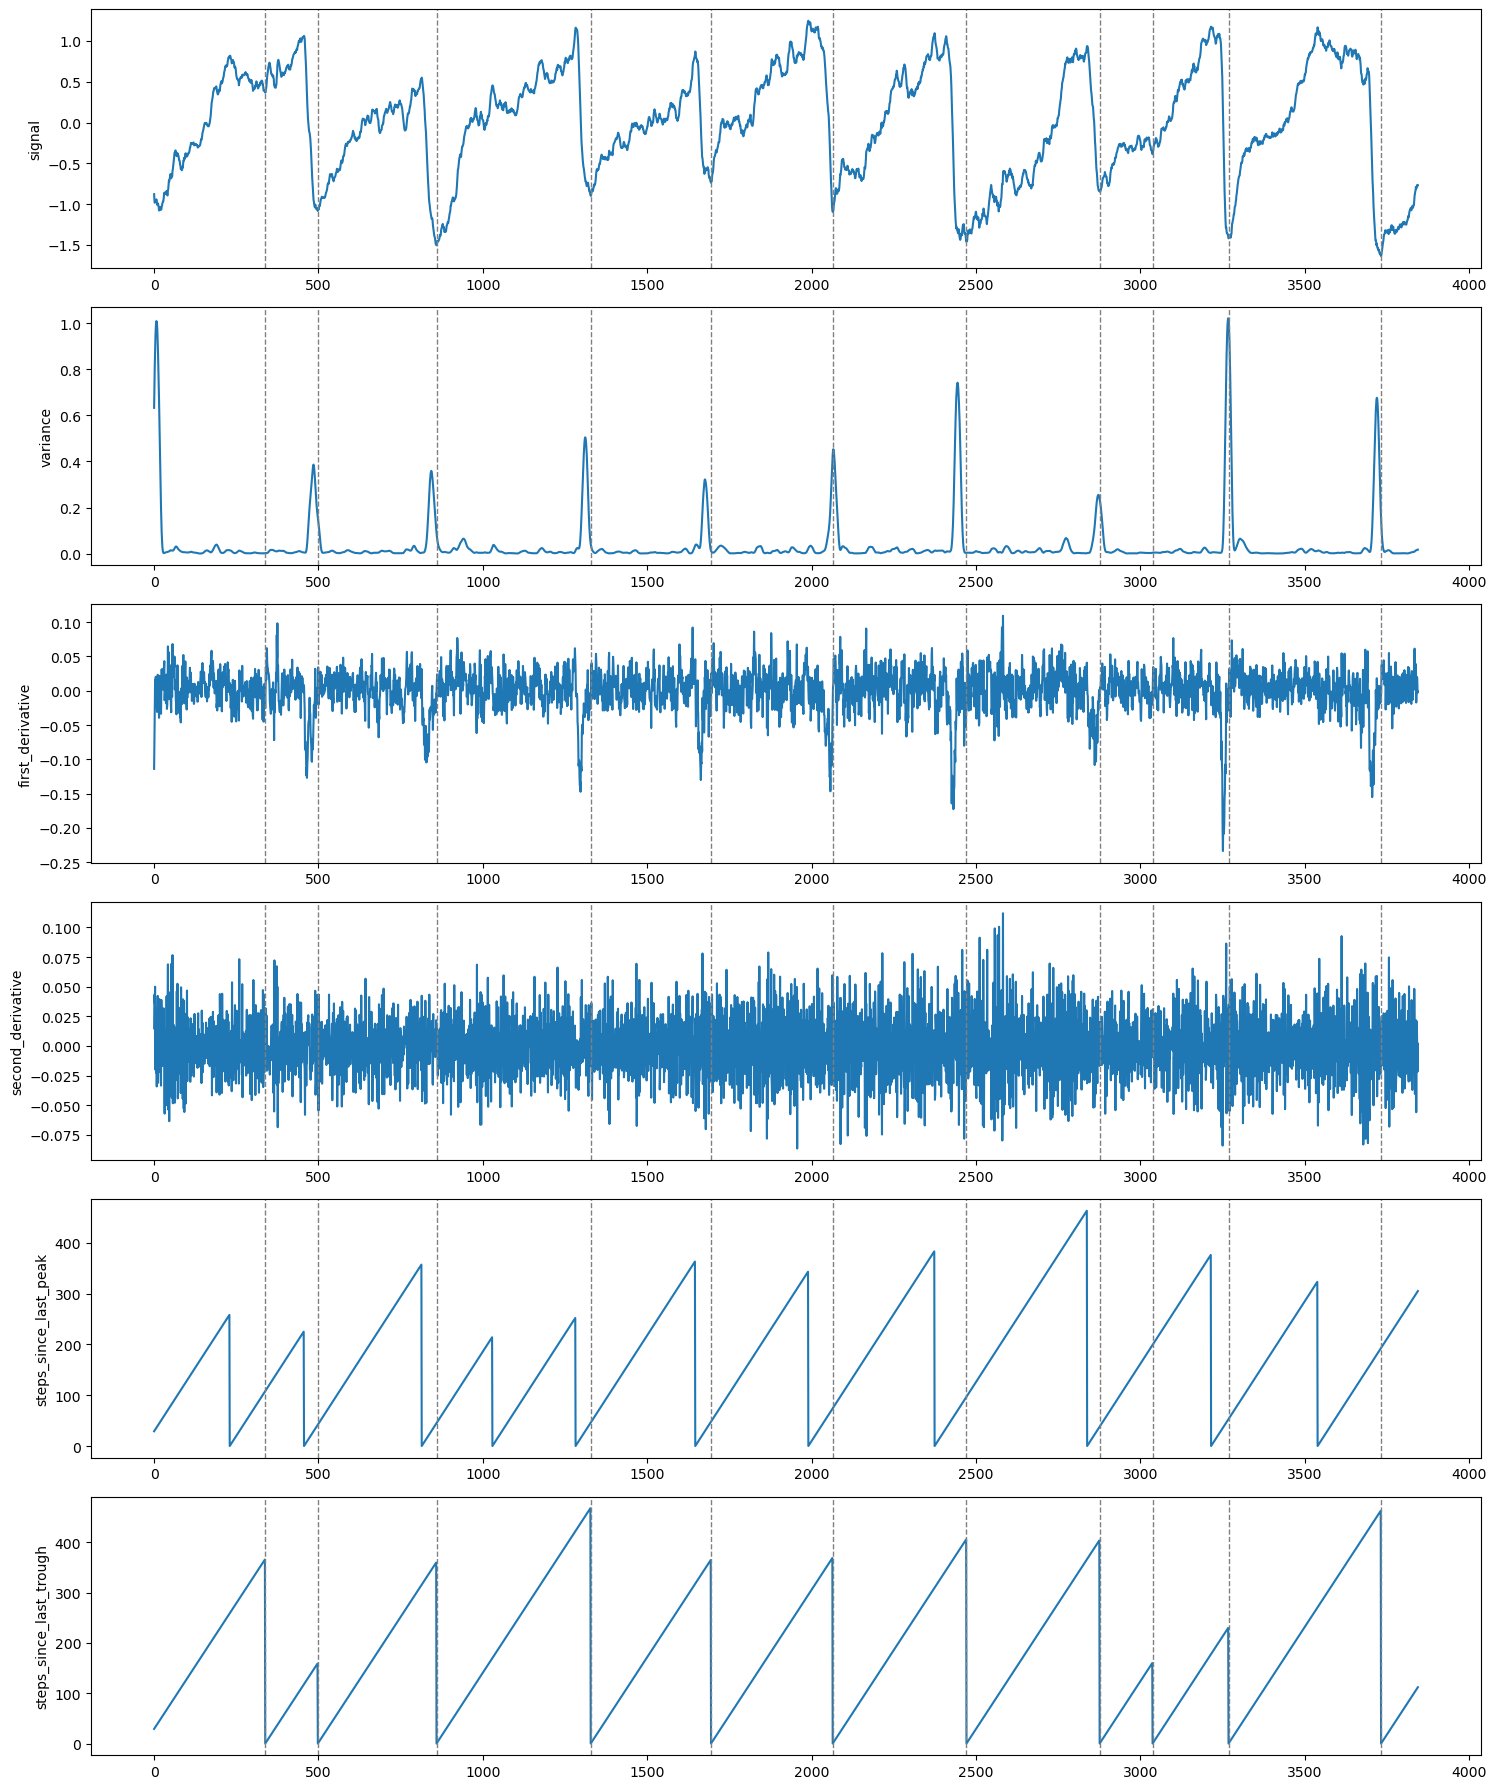

In [6]:
fig, axs = plt.subplots(
    len(df_features.columns), 1, figsize=(15, 3 * len(df_features.columns))
)

for i, column in enumerate(df_features.columns):
    ax = axs[i]
    ax.plot(df_features.index, df_features[column])
    ax.set_ylabel(column)
    ax.grid(False)

    # Mark where steps_since_last_trough = 0 with a black dashed line
    troughs_indices = df_features[
        df_features["steps_since_last_trough"] == 0
    ].index
    for trough_index in troughs_indices:
        ax.axvline(x=trough_index, color="grey", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()

___
## Step 6: Create train, validation and test sets
x

In [7]:
LOOKBACK, FORECAST = 600, 30  # need to adjust back to 60
X, y = create_dataset(df_features, LOOKBACK, FORECAST)

print(f"X and y shapes:\t{X.shape}\t{y.shape}")

X and y shapes:	torch.Size([3216, 600, 6])	torch.Size([3216, 30, 6])


In [8]:
N_FORECAST_WINDOWS = 12
N_VALIDATION_WINDOWS = 12

(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
) = split_train_test_forecast_windows(
    X, y, FORECAST, N_FORECAST_WINDOWS, N_VALIDATION_WINDOWS
)

print("Split dataset statistics:")
print(f"Training data shapes:\t\t{X_train.shape}\t\t{y_train.shape}")
print(f"Testing data shapes:\t\t{X_val.shape}\t\t{y_val.shape}")
print(f"Validation data shapes:\t\t{X_test.shape}\t\t{y_test.shape}")

Split dataset statistics:
Training data shapes:		torch.Size([2490, 600, 6])		torch.Size([2490, 30, 6])
Testing data shapes:		torch.Size([360, 600, 6])		torch.Size([360, 30, 6])
Validation data shapes:		torch.Size([360, 600, 6])		torch.Size([360, 30, 6])


___
## Step 7: Normalisation

In [9]:
data_dict_temp, scalers_X, scalers_y = normalise_dataset_multi_feature(
    X_train, y_train, X_test, y_test, X_val, y_val
)

print(f"Data Dictionary keys:\t{data_dict_temp.keys()}")
print("------------------")
print("Original dataset statistics:")
print(f"Training data shapes:\t\t{data_dict_temp['X_train'].shape}\t\t{data_dict_temp['y_train'].shape}")
print(f"Testing data shapes:\t\t{data_dict_temp['X_val'].shape}\t\t{data_dict_temp['y_val'].shape}")
print(f"Validation data shapes:\t\t{data_dict_temp['X_test'].shape}\t\t{data_dict_temp['y_test'].shape}")
print("------------------")
print("Normalised dataset statistics:")
print(f"Training data shapes:\t\t{data_dict_temp['X_train_sc'].shape}\t\t{data_dict_temp['y_train_sc'].shape}")
print(f"Validation data shapes:\t\t{data_dict_temp['X_val_sc'].shape}\t\t{data_dict_temp['y_val_sc'].shape}")
print(f"Testing data shapes:\t\t{data_dict_temp['X_test_sc'].shape}\t\t{data_dict_temp['y_test_sc'].shape}")

Data Dictionary keys:	dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])
------------------
Original dataset statistics:
Training data shapes:		torch.Size([2490, 600, 6])		torch.Size([2490, 30, 6])
Testing data shapes:		torch.Size([360, 600, 6])		torch.Size([360, 30, 6])
Validation data shapes:		torch.Size([360, 600, 6])		torch.Size([360, 30, 6])
------------------
Normalised dataset statistics:
Training data shapes:		torch.Size([2490, 600, 6])		torch.Size([2490, 30, 6])
Validation data shapes:		torch.Size([360, 600, 6])		torch.Size([360, 30, 6])
Testing data shapes:		torch.Size([360, 600, 6])		torch.Size([360, 30, 6])


___
## Step 8: Select the required features for training

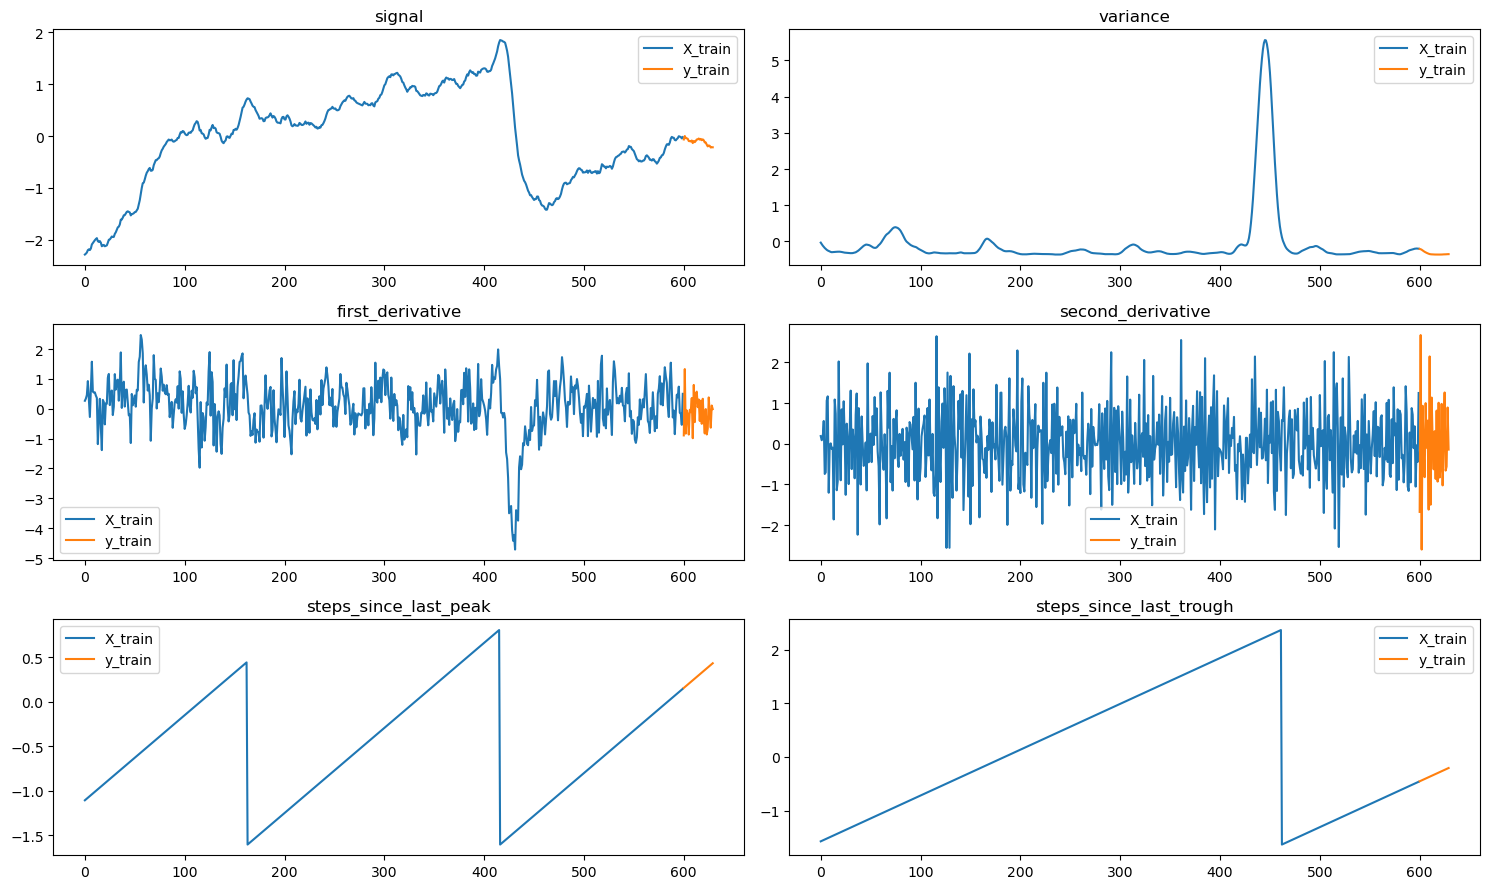

In [10]:
# Initial plot
feature_list = df_features.columns
plot_random_window(data_dict_temp, feature_list)

In [11]:
features_to_keep = ["signal", "variance"]
data_dict = select_features(data_dict_temp, features_to_keep)

print(f"Data Dictionary keys:\t{data_dict.keys()}")
print("------------------")
print("Original dataset statistics:")
print(f"Training data shapes:\t\t{data_dict['X_train'].shape}\t\t{data_dict['y_train'].shape}")
print(f"Testing data shapes:\t\t{data_dict['X_val'].shape}\t\t{data_dict['y_val'].shape}")
print(f"Validation data shapes:\t\t{data_dict['X_test'].shape}\t\t{data_dict['y_test'].shape}")
print("------------------")
print("Normalised dataset statistics:")
print(f"Training data shapes:\t\t{data_dict['X_train_sc'].shape}\t\t{data_dict['y_train_sc'].shape}")
print(f"Validation data shapes:\t\t{data_dict['X_val_sc'].shape}\t\t{data_dict['y_val_sc'].shape}")
print(f"Testing data shapes:\t\t{data_dict['X_test_sc'].shape}\t\t{data_dict['y_test_sc'].shape}")


Data Dictionary keys:	dict_keys(['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val', 'X_train_sc', 'X_test_sc', 'X_val_sc', 'y_train_sc', 'y_test_sc', 'y_val_sc'])
------------------
Original dataset statistics:
Training data shapes:		torch.Size([2490, 600, 2])		torch.Size([2490, 30])
Testing data shapes:		torch.Size([360, 600, 2])		torch.Size([360, 30])
Validation data shapes:		torch.Size([360, 600, 2])		torch.Size([360, 30])
------------------
Normalised dataset statistics:
Training data shapes:		torch.Size([2490, 600, 2])		torch.Size([2490, 30])
Validation data shapes:		torch.Size([360, 600, 2])		torch.Size([360, 30])
Testing data shapes:		torch.Size([360, 600, 2])		torch.Size([360, 30])


___
## Step 9: Initialise and train the model

In [12]:
# Model variables
N_VARIATES = data_dict["X_train"].shape[2]
HIDDEN_SIZE = 25
OUTPUT_SIZE = FORECAST
N_EPOCHS = 1
N_LAYERS = 1
scaler_y = scalers_y[0]

model = lstm.MultiStepLSTMSingleLayer(
    N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device
).to(device)

In [13]:
results_dict = train_model_multi_feature(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cpu


Epoch [1/1], Train RMSE: 0.4109, Val RMSE: 0.5026: 100%|██████████| 1/1 [00:41<00:00, 41.62s/it]


___
## Step 10: Evaluate the model's performance and plot sample test windows

In [14]:

results_dict = eval_model_on_test_set_multi_feature(
    model, results_dict, data_dict, scaler_y, device
)

print("Train RMSE:", results_dict["train_rmse_list"][-1])
print("Val RMSE:", results_dict["val_rmse_list"][-1])
print("Test RMSE:", results_dict["test_rmse_list"])
print("--------------")
print("Train R^2:", results_dict["train_r2_list"][-1])
print("Val R^2:", results_dict["val_r2_list"][-1])
print("Test R^2:", results_dict["test_r2_list"])
print("--------------")

# Identify and print the five lowest validation RMSEs and their corresponding epochs and R^2 values
print("Five lowest Validation RMSEs:")
for index, loss in sorted(enumerate(results_dict["val_rmse_list"]), key=lambda x: x[1])[:5]:
    print(f"Epoch: {index + 1}, Value: {loss} (R^2: {results_dict['val_r2_list'][index]})")

Train RMSE: 0.410928875207901
Val RMSE: 0.5025997757911682
Test RMSE: 0.6787912845611572
--------------
Train R^2: 0.5517696823653382
Val R^2: 0.44569977846237213
Test R^2: 0.5421121835155382
--------------
Five lowest Validation RMSEs:
Epoch: 1, Value: 0.5025997757911682 (R^2: 0.44569977846237213)


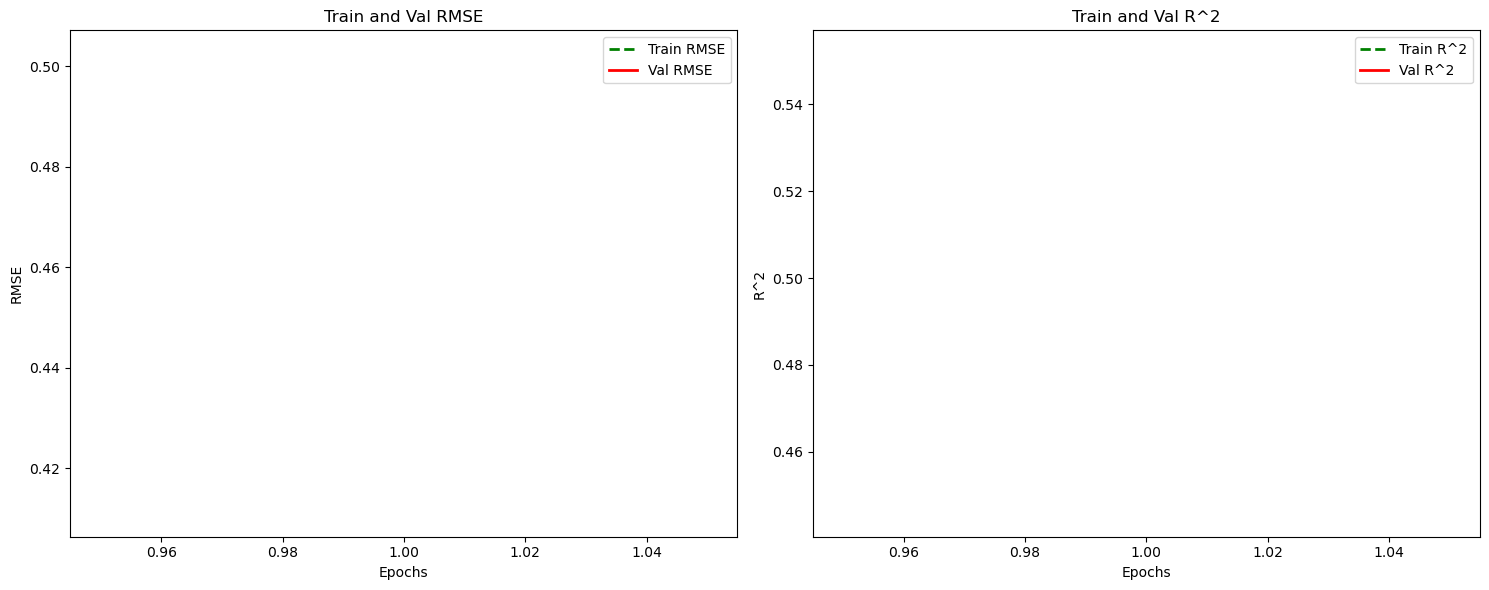

In [15]:
# Plotting RMSE and R^2 for train and validation sets
train_rmse_list, val_rmse_list = results_dict["train_rmse_list"], results_dict["val_rmse_list"]
train_r2_list, val_r2_list = results_dict["train_r2_list"], results_dict["val_r2_list"]
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# RMSE plot
axs[0].plot(range(1, len(train_rmse_list) + 1), train_rmse_list, label="Train RMSE", color="green", linestyle="--", linewidth=2)
axs[0].plot(range(1, len(val_rmse_list) + 1), val_rmse_list, label="Val RMSE", color="red", linestyle="-", linewidth=2)
axs[0].set(title="Train and Val RMSE", xlabel="Epochs", ylabel="RMSE")
axs[0].legend()

# R^2 plot
axs[1].plot(range(1, len(train_r2_list) + 1), train_r2_list, label="Train R^2", color="green", linestyle="--", linewidth=2)
axs[1].plot(range(1, len(val_r2_list) + 1), val_r2_list, label="Val R^2", color="red", linestyle="-", linewidth=2)
axs[1].set(title="Train and Val R^2", xlabel="Epochs", ylabel="R^2")
axs[1].legend()

plt.tight_layout()
plt.show()

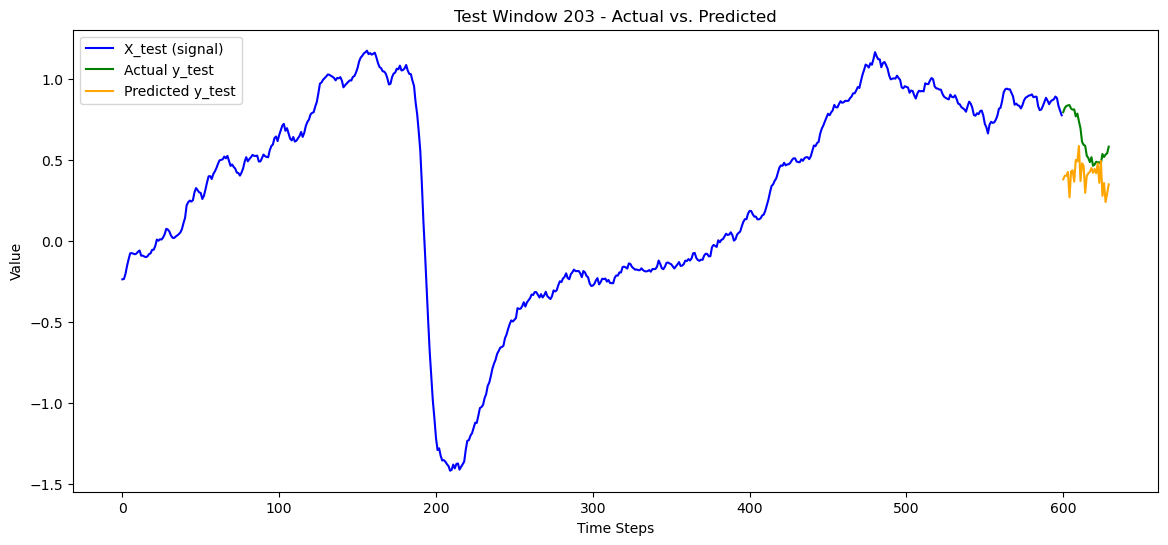

In [16]:
plot_random_test_window(data_dict, results_dict)